# Introduction

This notebook will perform experiments and explore the sklearn implementations of algorithms that assume a linear relation between the features and the target variable. After extensively exploring the performance of these algorithm for different data configurations (with varying number of features, number of observations, type of targets, type of processing), we will test the most meaningful findings with the house price competition data, trying to find our learning again in those settings.

For a broad introduction on linear models, please refer to https://en.wikipedia.org/wiki/Linear_regression or to any good book of statistics. Here a quick summary

The main assumption of such models is that the target `y` is related with the explanatory variables as $$y = \alpha + \beta_1 x_1 + \dots + \beta_n x_n,$$
and our goal is to estimate the values of $\alpha$ and $\beta_i$.

The other assumptions for most of the models are
* Constant variance (homoscedasticity) of the errors, independently of the value of the variables. This assumption simplifies the computation.
* Independence of errors of the predicted target variable, which should not have correlation
* No perfect multicollinearity between the variables
* The predictors are assumed to be error free

In [1]:
import pandas as pd
import numpy as np

import source.hyperplots as hyp
import source.explore as exp
from source.report import plot_predictions, make_results, store_results
from source.utility import cv_score, grid_search
import source.transf_univ as df_p

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge, Perceptron

%matplotlib inline
pd.set_option('max_columns', 500)

In [2]:
numeric_pipe = Pipeline([('fs', df_p.feat_sel('numeric')),
                         ('imputer', df_p.df_imputer(strategy='median'))])


cat_pipe = Pipeline([('fs', df_p.feat_sel('category')),
                     ('imputer', df_p.df_imputer(strategy='most_frequent')), 
                     ('dummies', df_p.dummify())])

processing_pipe = df_p.FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                    ('num_pipe', numeric_pipe)])

model = Pipeline([('processing', processing_pipe),
                  ('scl', df_p.df_scaler()), 
                  ('linear', LinearRegression())])

kfolds = KFold(10, shuffle=True, random_state=541)

The simplest LinearRegression can be implemented as above, we can quickly test it via the functions we developed in Notebook 02.

For example, we see that for a target generated by a linear function of the features we get a very good model

In [3]:
df = pd.read_csv('data/simulated/clean.csv')

df_train = df[[col for col in df.columns if not col.startswith('tar_') and 'unc' in col]].copy()

target = df['tar_lin_unc']

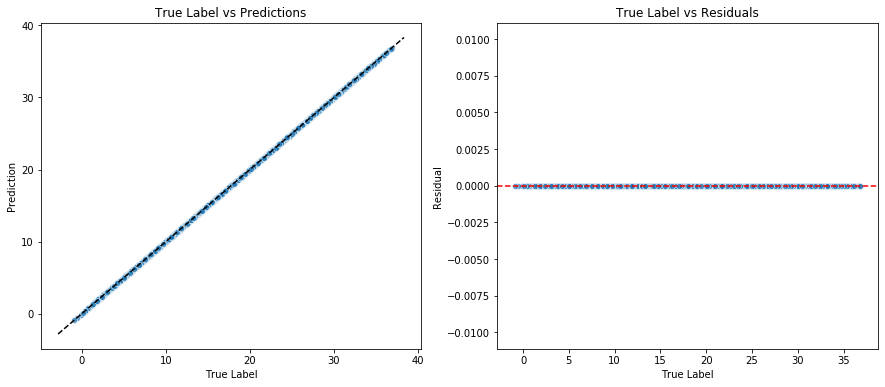

In [4]:
oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

However, we see that not necessarily we estimate the coefficients correctly (we will see why)

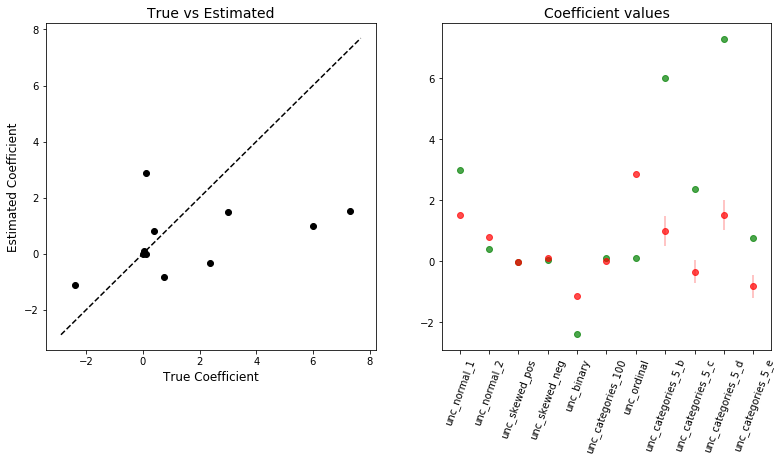

In [5]:
hyp.plot_coefficients('tar_lin_unc', coefs_est)

In [6]:
res = make_results(label=target, prediction=oof, model='LinearRegression', 
                   parameters={'standard'}, 
                   target_name='tar_lin_unc', variables='unc', instances=100000, verbose=True)

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


On the other hand, we see that if the target is generated non-linearly, the model performs poorly

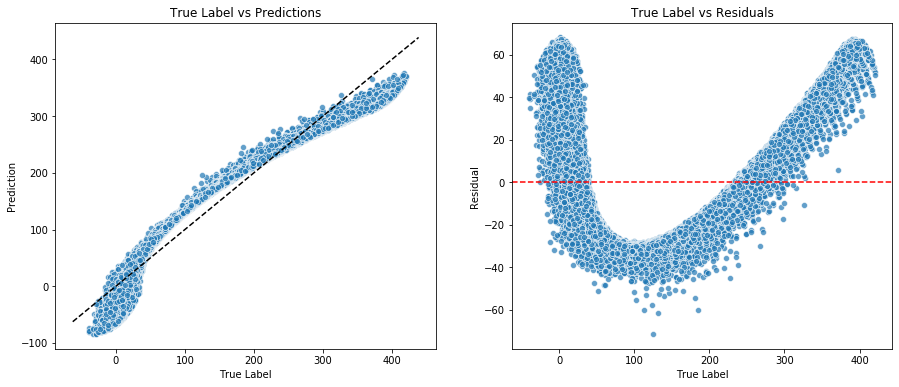

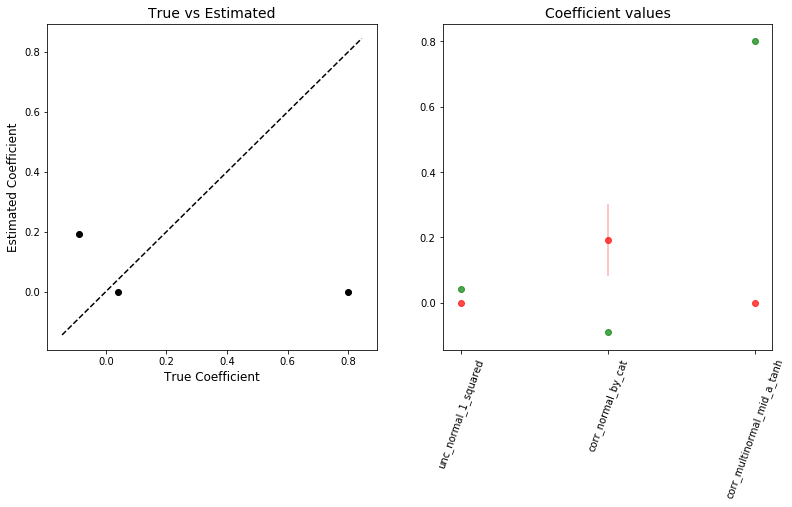

MAE: 		 25.16247
MSE: 		 856.86992
Max Error: 	 71.33318
Expl Variance: 	 0.93908


In [7]:
df_train = df[[col for col in df.columns if not col.startswith('tar_')]].copy()

target = df['tar_nonlin_3']

oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

hyp.plot_coefficients('tar_nonlin_3', coefs_est)

res = make_results(label=target, prediction=oof, model='LinearRegression', 
                   parameters={'standard'}, 
                   target_name='tar_nonlin_3', variables='All', instances=100000, verbose=True)

Please keep in mind that the plot of the coefficients in plotting a point at 0 if the real coefficient can't be found in the estimated one (for example if it is the coefficient of a variable that does not exists in our data)

For each model, we will have a look at these metrics and store the results when needed. We will iterate on different data and model configurations with the goal of understanding how all these moving parts are playing with one another.

# Experiments

## LinearRegression

We have seen already that if the target is linearly generated, we can perfectly fit the data (please keep in mind that all the predictions and the scores are referring to the performance on an holdout set with a 10 fold CV scheme). The model has very few hyperparameters ([see the sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)) and we thus investigate the performance of the model when we change the input data.

In [8]:
LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Linear functions, noise, correlation

In this section, we see how `LinearRegression` can fit data and predict a target variable generated by a linear relation.

First, we use a dataset of 100000 observations, 10 variables, all of which were used to generate the target without noise.

In [22]:
def experiment_lr(data_name, kfolds, store=False):
    df = pd.read_csv(data_name)
    
    coefs_name = data_name.split('.csv')[0] + '__coefficients.csv'
    target_name = data_name.split('/')[2].split('.csv')[0]

    target = df['target']

    df_train = df.drop('target', axis=1)

    model = Pipeline([('processing', numeric_pipe),
                      ('scl', df_p.df_scaler()), 
                      ('linear', LinearRegression())])

    oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

    plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

    hyp.plot_coefficients('tar_nonlin_3', coefs_est, 
                          coefs_real=coefs_name)
    
    if store:
        store_results('data/03_linear_models.csv', 
                      label=target, prediction=oof, model='LinearRegression', 
                      parameters={'Irrelavant'}, 
                      target_name=target_name, variables='All', instances=df_train.shape[0], verbose=True)
    else:
        res = make_results(label=target, prediction=oof, model='LinearRegression', 
                           parameters={'Irrelavant'}, 
                           target_name=target_name, variables='All', instances=df_train.shape[0], verbose=True)
    

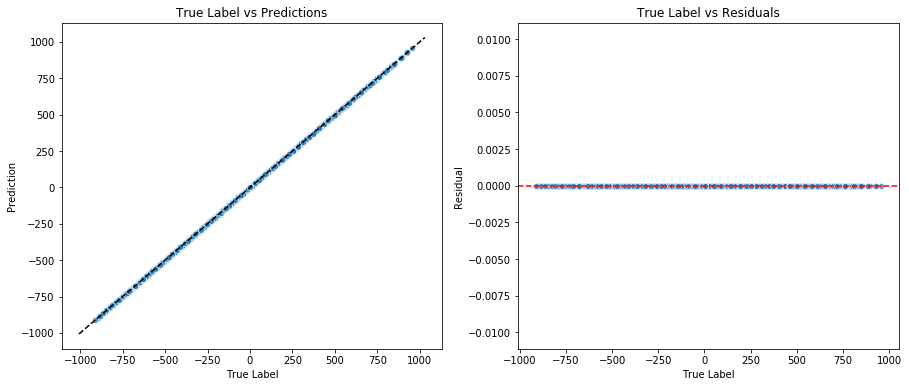

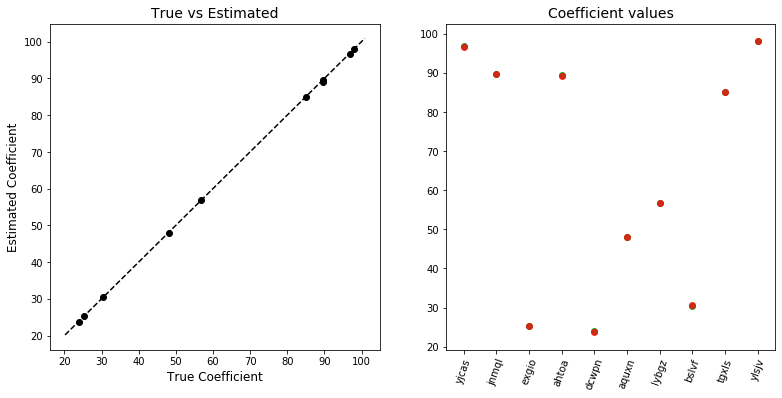

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


In [27]:
experiment_lr('data/simulated/10_feat_10_inf_nonoise.csv', kfolds, store=True)

However, already using a target generated with some **noise** we notice a significant drop in performance

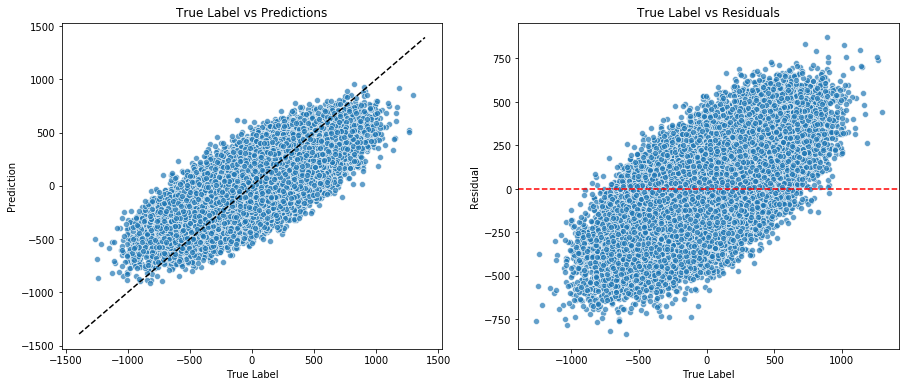

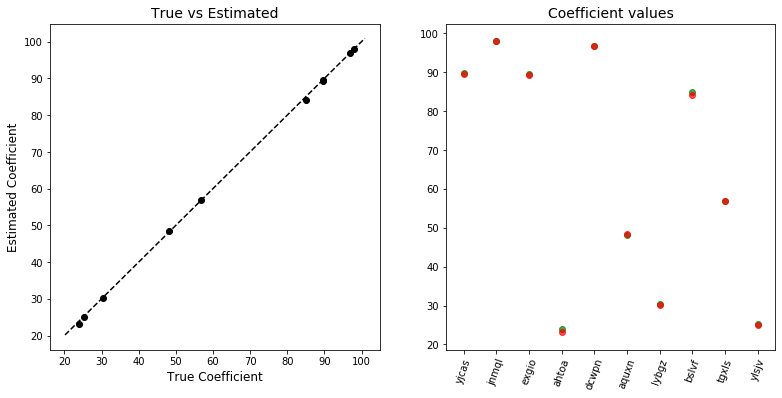

MAE: 		 159.15957
MSE: 		 39903.46378
Max Error: 	 870.78547
Expl Variance: 	 0.55337


In [28]:
experiment_lr('data/simulated/10_feat_10_inf_noise.csv', kfolds, store=True)

Still a reasonably good estimation of the coefficients, something that deteriorates if we have more coefficients (for example, 65 informative features over 100 available)

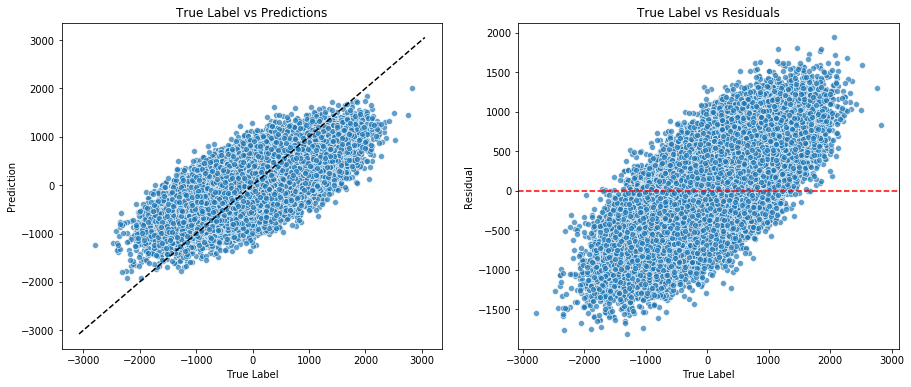

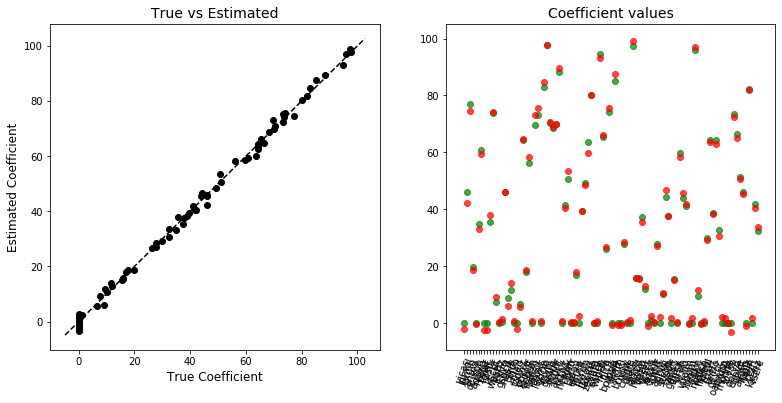

MAE: 		 359.51792
MSE: 		 202633.44246
Max Error: 	 1939.61267
Expl Variance: 	 0.48907


In [29]:
experiment_lr('data/simulated/100_feat_65_inf_noise.csv', kfolds, store=True)

Or that we completely lose if we introduce correlation among the features

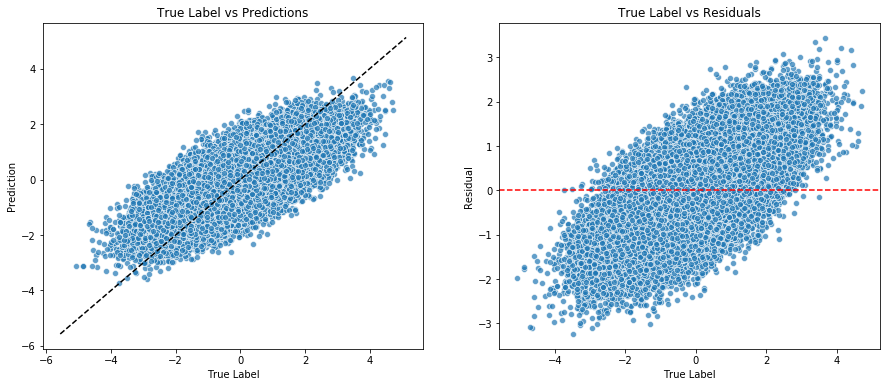

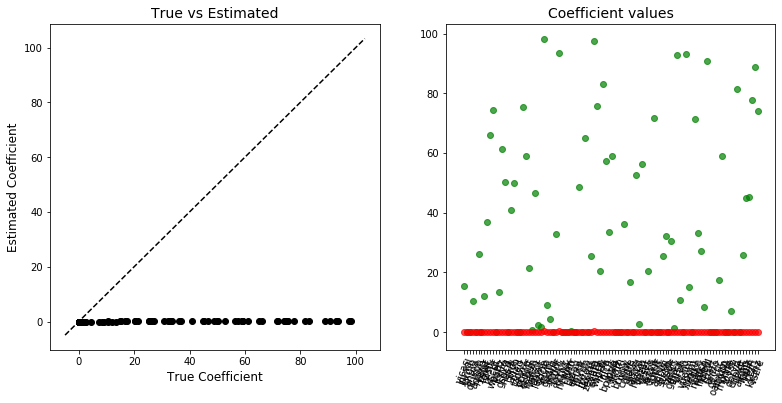

MAE: 		 0.63864
MSE: 		 0.63961
Max Error: 	 3.43738
Expl Variance: 	 0.53145


In [30]:
experiment_lr('data/simulated/100_feat_65_inf_noise_rank.csv', kfolds, store=True)

# Real application - HousePrice

# Conclusion